In [1]:
#%env CUDA_VISIBLE_DEVICES=1

In [1]:
from collections import Counter
from glob import glob
from itertools import islice

import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import scipy
from scipy.cluster import hierarchy
import seaborn as sns
import torch
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from era_data import TabletPeriodDataset
from era_model import EraClassifier

# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load data and model

In [3]:
IMG_DIR = 'output/images_preprocessed'

VERSION_NAME = 'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples-preprocessed_April16-80-10-10-train_test_val'

#'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples-preprocessed_April13-80-20_1kval'

#'period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples-preprocessed_April08-70-10-20_train_test_val2'

#'period_clf_bs16_lr5e-05_20epochs-resnet50-94936_samples-preprocessed_March28-1000_test_val'

CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr1e-05_20epochs-resnet50-94936_samples-preprocessed_April16-80-10-10-train_test_val/checkpoints/epoch=3-step=18513.ckpt'

In [4]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2
num_classes

24

In [5]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 821 ms, sys: 303 ms, total: 1.12 s
Wall time: 745 ms


In [6]:
model.to(device);

In [7]:
model.eval();

In [9]:
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [10]:
len(test_ids)

9494

In [11]:
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR)

Filtering 94936 IDS down to provided 9494...


In [12]:
def collate_fn(batch):
    
    data = torch.stack([torch.from_numpy(sample[1]) for sample in batch])
    labels = torch.tensor([sample[2] for sample in batch])

    return data, labels

In [13]:
dl_test = DataLoader(ds_test, batch_size=16, collate_fn = collate_fn, shuffle=False, num_workers=1)

# Calculate predictions

In [14]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [15]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/582 [00:00<?, ?it/s]

In [16]:
y_true.shape, logits.shape

((9297,), (9297, 24))

In [17]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [18]:
y_pred.shape, y_prob.shape

((9297,), (9297, 24))

In [19]:
(y_pred == y_true).mean()

0.8412391093901258

# Check metrics

In [20]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [21]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [22]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [23]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [24]:
list(set(y_true) | set(y_pred))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [25]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

22
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Proto-Elamite (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)', 'Hellenistic (I)', 'ED I-II (EB)', 'Middle Elamite (MLB)', 'Middle Hittite (MLB)', 'Uruk IV (EB)']


In [26]:
print(classification_report(y_true, y_pred, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       0.40      0.04      0.07        49
               Ur III (EB)       0.94      0.94      0.94      2799
          Neo-Assyrian (I)       0.97      0.98      0.98      2304
      Old Babylonian (MLB)       0.69      0.87      0.77      1671
   Middle Babylonian (MLB)       0.64      0.60      0.62       602
        Neo-Babylonian (I)       0.67      0.57      0.62       502
         Old Akkadian (EB)       0.84      0.73      0.78       304
            Achaemenid (I)       0.88      0.36      0.52       200
Early Old Babylonian (MLB)       0.72      0.37      0.49       205
              ED IIIb (EB)       0.73      0.77      0.75       154
     Middle Assyrian (MLB)       0.58      0.69      0.63       149
        Old Assyrian (MLB)       0.98      0.82      0.89       147
             Uruk III (EB)       0.65      0.74      0.69        23
        Proto-Elamite (EB)       0.00      0.00

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [33]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 40})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (14)


[(0, 'other (?)'),
 (1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (8, 'Early Old Babylonian (MLB)'),
 (9, 'ED IIIb (EB)'),
 (10, 'Middle Assyrian (MLB)'),
 (11, 'Old Assyrian (MLB)'),
 (14, 'Lagash II (EB)'),
 (15, 'Ebla (EB)')]

In [34]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 0
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.010648596321393998 changed to "other"


In [35]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 0
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.009142734215338282 changed to "other"


In [36]:
set(y_true_c) | set(y_pred_c)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15}

In [37]:
explain(idx2period[20])

'Middle Hittite (MLB)'

In [38]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

14
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Lagash II (EB)', 'Ebla (EB)']


In [39]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.53      0.32      0.40       148
               Ur III (EB)       0.94      0.94      0.94      2799
          Neo-Assyrian (I)       0.97      0.98      0.98      2304
      Old Babylonian (MLB)       0.69      0.87      0.77      1671
   Middle Babylonian (MLB)       0.64      0.60      0.62       602
        Neo-Babylonian (I)       0.67      0.57      0.62       502
         Old Akkadian (EB)       0.84      0.73      0.78       304
            Achaemenid (I)       0.88      0.36      0.52       200
Early Old Babylonian (MLB)       0.72      0.37      0.49       205
              ED IIIb (EB)       0.73      0.77      0.75       154
     Middle Assyrian (MLB)       0.58      0.69      0.63       149
        Old Assyrian (MLB)       0.98      0.82      0.89       147
            Lagash II (EB)       0.74      0.67      0.70        64
                 Ebla (EB)       0.81      0.88

In [40]:
Y = label_binarize(y_true, classes=np.unique(y_true))
n_classes = Y.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(Y[:, i], y_prob[:, i])
    auc_scores.append(auc)

macro_ovr_auc = np.mean(auc_scores)
print(f"Macro-OvR-AUC: {macro_ovr_auc}")

Macro-OvR-AUC: 0.9699503027845442


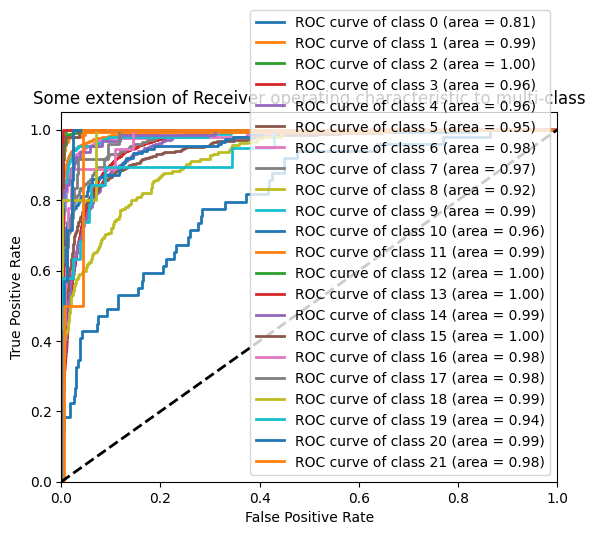

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y[:, i], y_prob[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [42]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[  48,   14,    8,   42,    3,   10,    2,    1,    1,    7,    8,
           1,    0,    3],
       [   2, 2627,    3,  101,   20,    4,   18,    0,    6,    7,    5,
           1,    5,    0],
       [   1,    4, 2255,   17,    1,   12,    0,    0,    0,    0,   14,
           0,    0,    0],
       [   8,   57,   10, 1453,   72,   44,    3,    0,   10,    1,   11,
           0,    0,    2],
       [   1,    9,    2,  201,  361,   12,    1,    0,    6,    0,    9,
           0,    0,    0],
       [   9,   11,   13,  108,   43,  286,    0,    9,    2,    0,   21,
           0,    0,    0],
       [   6,   18,    1,   15,    7,    3,  222,    0,    0,   21,    0,
           0,    8,    3],
       [   3,    5,    4,   39,   28,   43,    0,   73,    0,    0,    5,
           0,    0,    0],
       [   0,   20,    2,   87,   15,    3,    0,    0,   75,    1,    0,
           0,    2,    0],
       [   6,    3,    2,    6,    5,    1,   11,    0,    0,  118,    0,
           0,    

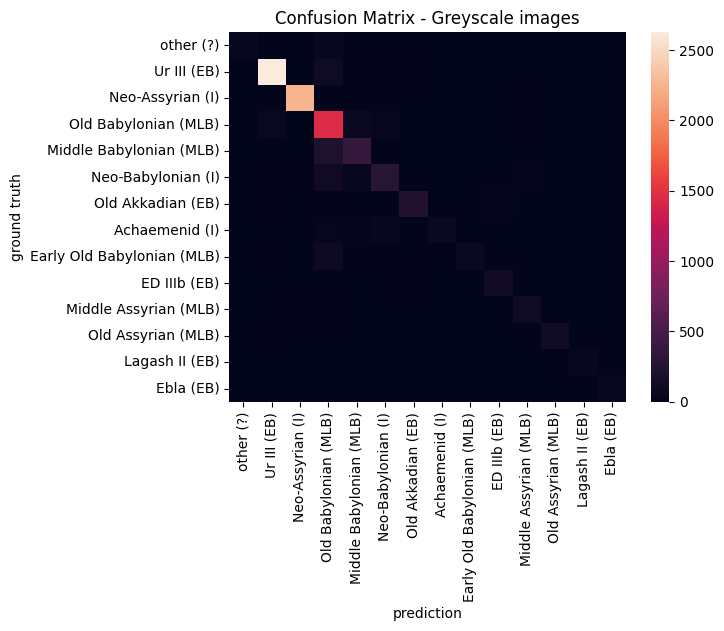

In [43]:
sns.heatmap(cm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Greyscale images");

In [44]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

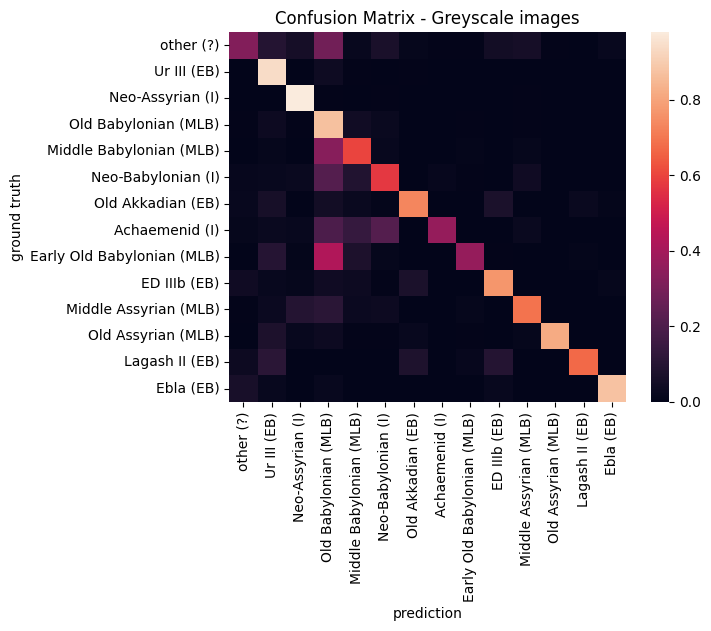

In [45]:
sns.heatmap(cm_rownorm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Greyscale images");

In [46]:
cm_df = pd.DataFrame(cm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB),Old Assyrian (MLB),Lagash II (EB),Ebla (EB)
other (?),48,14,8,42,3,10,2,1,1,7,8,1,0,3
Ur III (EB),2,2627,3,101,20,4,18,0,6,7,5,1,5,0
Neo-Assyrian (I),1,4,2255,17,1,12,0,0,0,0,14,0,0,0
Old Babylonian (MLB),8,57,10,1453,72,44,3,0,10,1,11,0,0,2
Middle Babylonian (MLB),1,9,2,201,361,12,1,0,6,0,9,0,0,0
Neo-Babylonian (I),9,11,13,108,43,286,0,9,2,0,21,0,0,0
Old Akkadian (EB),6,18,1,15,7,3,222,0,0,21,0,0,8,3
Achaemenid (I),3,5,4,39,28,43,0,73,0,0,5,0,0,0
Early Old Babylonian (MLB),0,20,2,87,15,3,0,0,75,1,0,0,2,0
ED IIIb (EB),6,3,2,6,5,1,11,0,0,118,0,0,0,2


In [47]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_rn_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB),Old Assyrian (MLB),Lagash II (EB),Ebla (EB)
other (?),0.324324,0.094595,0.054054,0.283784,0.020270,0.067568,0.013514,0.006757,0.006757,0.047297,0.054054,0.006757,0.000000,0.020270
Ur III (EB),0.000715,0.938549,0.001072,0.036084,0.007145,0.001429,0.006431,0.000000,0.002144,0.002501,0.001786,0.000357,0.001786,0.000000
Neo-Assyrian (I),0.000434,0.001736,0.978733,0.007378,0.000434,0.005208,0.000000,0.000000,0.000000,0.000000,0.006076,0.000000,0.000000,0.000000
Old Babylonian (MLB),0.004788,0.034111,0.005984,0.869539,0.043088,0.026332,0.001795,0.000000,0.005984,0.000598,0.006583,0.000000,0.000000,0.001197
Middle Babylonian (MLB),0.001661,0.014950,0.003322,0.333887,0.599668,0.019934,0.001661,0.000000,0.009967,0.000000,0.014950,0.000000,0.000000,0.000000
Neo-Babylonian (I),0.017928,0.021912,0.025896,0.215139,0.085657,0.569721,0.000000,0.017928,0.003984,0.000000,0.041833,0.000000,0.000000,0.000000
Old Akkadian (EB),0.019737,0.059211,0.003289,0.049342,0.023026,0.009868,0.730263,0.000000,0.000000,0.069079,0.000000,0.000000,0.026316,0.009868
Achaemenid (I),0.015000,0.025000,0.020000,0.195000,0.140000,0.215000,0.000000,0.365000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000
Early Old Babylonian (MLB),0.000000,0.097561,0.009756,0.424390,0.073171,0.014634,0.000000,0.000000,0.365854,0.004878,0.000000,0.000000,0.009756,0.000000
ED IIIb (EB),0.038961,0.019481,0.012987,0.038961,0.032468,0.006494,0.071429,0.000000,0.000000,0.766234,0.000000,0.000000,0.000000,0.012987


In [48]:
cm_df.loc['Early Old Babylonian (MLB)']

other (?)                      0
Ur III (EB)                   20
Neo-Assyrian (I)               2
Old Babylonian (MLB)          87
Middle Babylonian (MLB)       15
Neo-Babylonian (I)             3
Old Akkadian (EB)              0
Achaemenid (I)                 0
Early Old Babylonian (MLB)    75
ED IIIb (EB)                   1
Middle Assyrian (MLB)          0
Old Assyrian (MLB)             0
Lagash II (EB)                 2
Ebla (EB)                      0
Name: Early Old Babylonian (MLB), dtype: int64

In [49]:
cm_rn_df.loc['Early Old Babylonian (MLB)']

other (?)                     0.000000
Ur III (EB)                   0.097561
Neo-Assyrian (I)              0.009756
Old Babylonian (MLB)          0.424390
Middle Babylonian (MLB)       0.073171
Neo-Babylonian (I)            0.014634
Old Akkadian (EB)             0.000000
Achaemenid (I)                0.000000
Early Old Babylonian (MLB)    0.365854
ED IIIb (EB)                  0.004878
Middle Assyrian (MLB)         0.000000
Old Assyrian (MLB)            0.000000
Lagash II (EB)                0.009756
Ebla (EB)                     0.000000
Name: Early Old Babylonian (MLB), dtype: float64

# Hierarchical clustering on confusion matrix

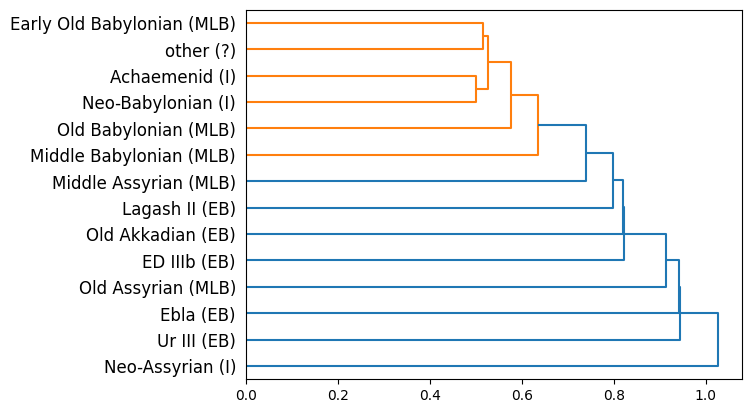

In [76]:
Y = hierarchy.distance.pdist(cm_rownorm, metric='euclidean')

Z = hierarchy.linkage(Y, method='single')

ax = hierarchy.dendrogram(Z, show_contracted=True, labels=PERIOD_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [51]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [52]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [53]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [54]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for _, X, y, _, _ in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)

In [55]:
feats = extract_features(dl_test)

  0%|          | 0/582 [00:00<?, ?it/s]

In [56]:
feats

array([[0.64561605, 0.7242762 , 0.4605153 , ..., 0.09635771, 0.64296424,
        0.54268074],
       [0.60724974, 0.37383404, 0.40104735, ..., 0.2033444 , 0.57020533,
        0.38884366],
       [0.6068152 , 0.3744781 , 0.5033756 , ..., 0.08204505, 0.42305803,
        0.56223917],
       ...,
       [0.569376  , 0.20366164, 0.3434532 , ..., 0.08362561, 0.42776972,
        0.60848504],
       [0.7187375 , 0.4368567 , 0.8759575 , ..., 0.08744374, 0.50782716,
        0.7718337 ],
       [0.5601597 , 0.2537439 , 0.3905397 , ..., 0.16006513, 0.23521665,
        0.6313821 ]], dtype=float32)

In [57]:
feats.shape

(9297, 2048)

In [58]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

CPU times: user 2min 44s, sys: 2.68 s, total: 2min 46s
Wall time: 29.2 s


In [59]:
%time F2 = Isomap(n_components=10).fit_transform(feats)

CPU times: user 2min 31s, sys: 11.4 s, total: 2min 42s
Wall time: 1min


Text(0.5, 1.0, 'ISOMAP')

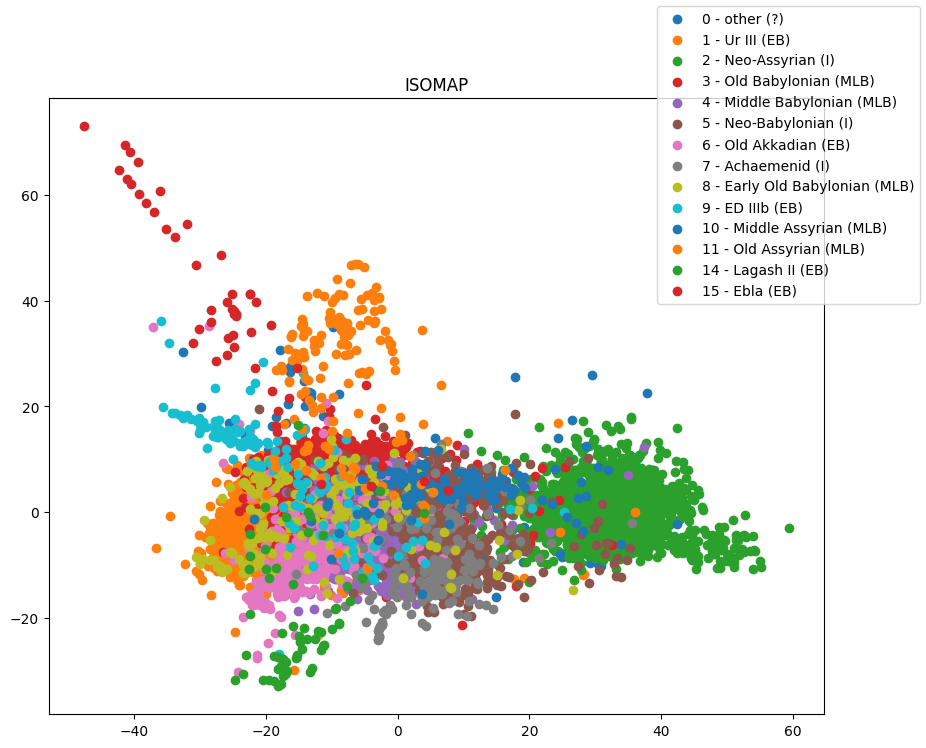

In [60]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F2[y_true_c == period, 0], F2[y_true_c == period, 4], label=f'{period} - {explain(idx2period[period])}')
fig.legend();
plt.title('ISOMAP')

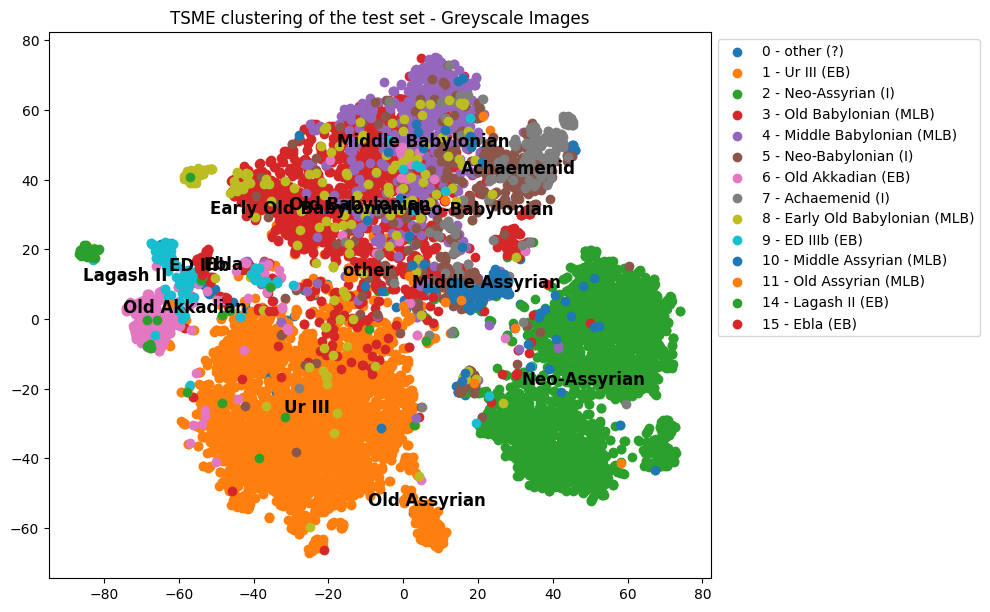

In [61]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for period in set(y_true_c):
    period_data = F[y_true_c == period]
    
    # Scatter plot for the period.
    ax.scatter(period_data[:, 0], period_data[:, 1], label=f'{period} - {explain(idx2period[period])}')
    
    centroid = np.mean(period_data, axis=0)
    
    ax.text(centroid[0], centroid[1], f'{idx2period[period]}', horizontalalignment='center', verticalalignment='center', fontsize=12, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('TSME clustering of the test set - Greyscale Images')
scatter_pdf_path = 'output/plots/TSNEclusteringGreyscale.pdf'
plt.savefig(scatter_pdf_path, format='pdf')

#plt.show()

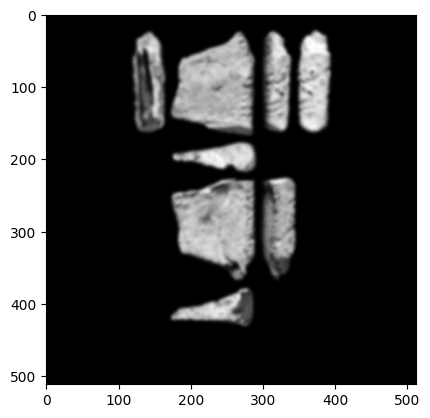

In [62]:
ID = np.random.choice(np.where(y_true == 2)[0])
plt.imshow(ds_test[ID][1], cmap='gray');

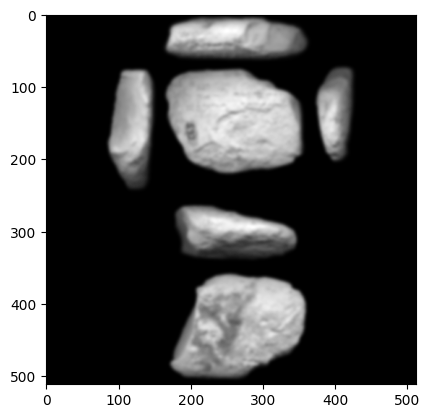

In [63]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][1], cmap='gray');

# Visualize mistakes

In [64]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([  12,   33,   54, ..., 9271, 9272, 9274])

In [65]:
mistake_indices.shape

(1476,)

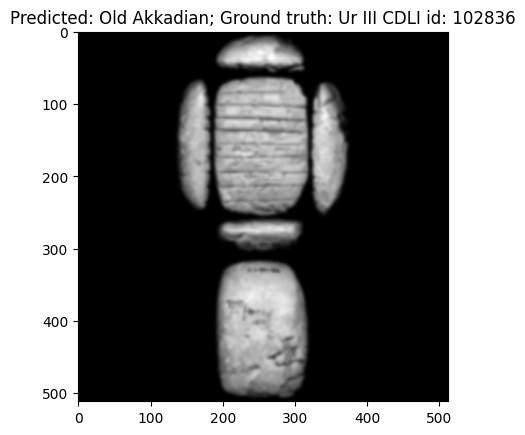

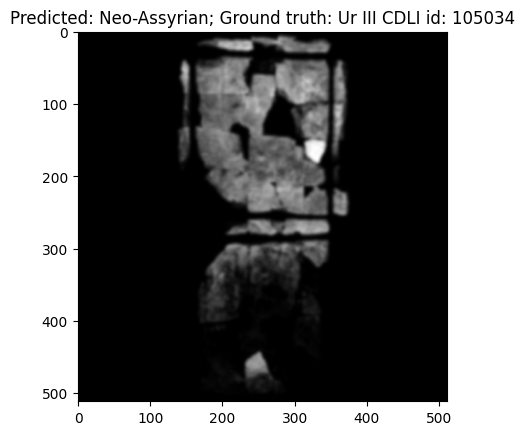

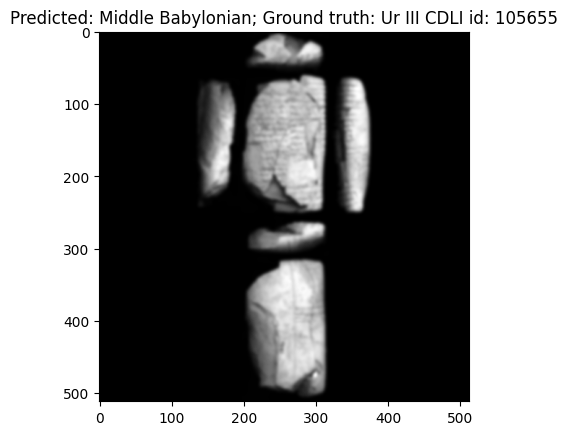

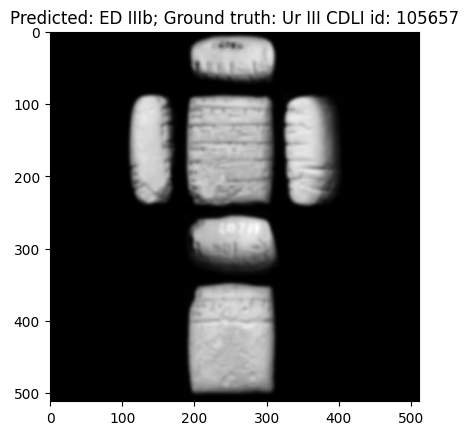

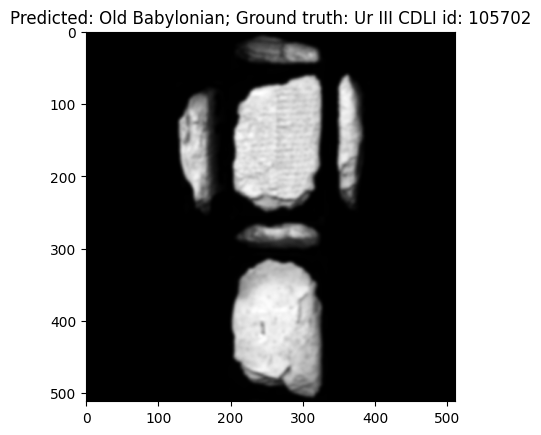

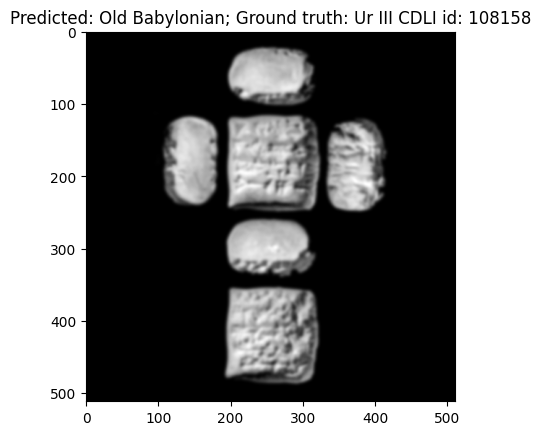

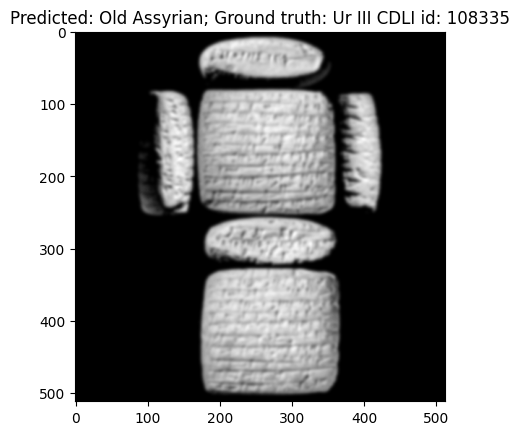

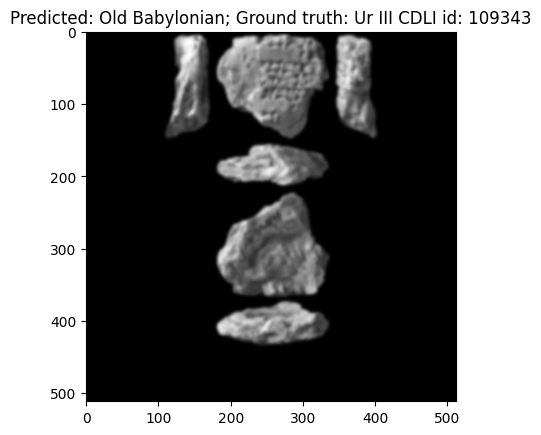

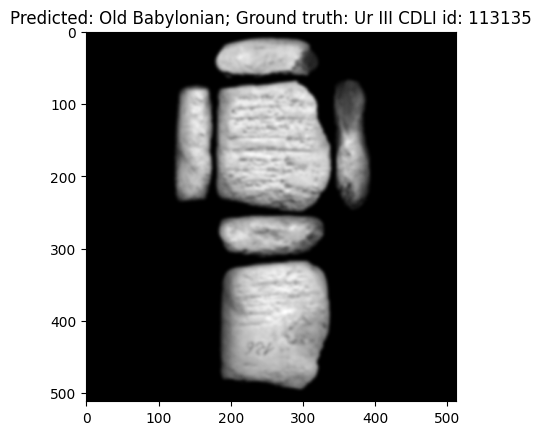

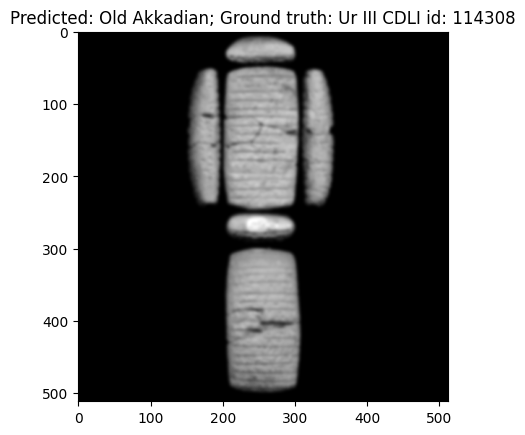

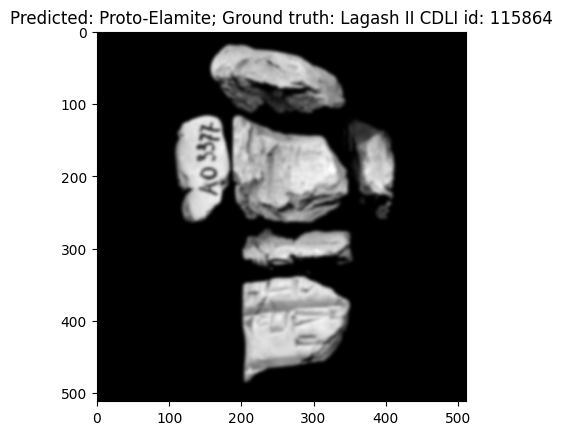

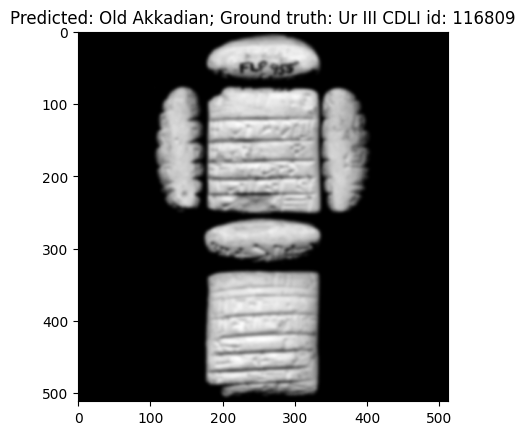

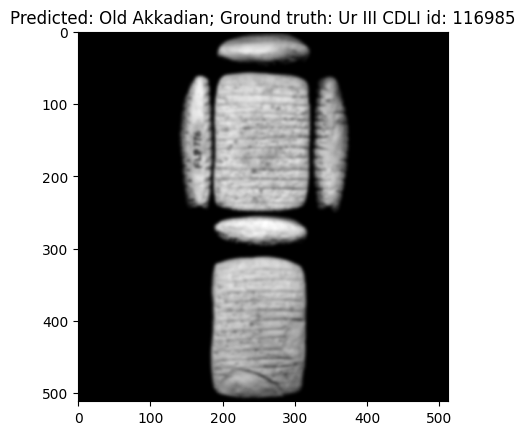

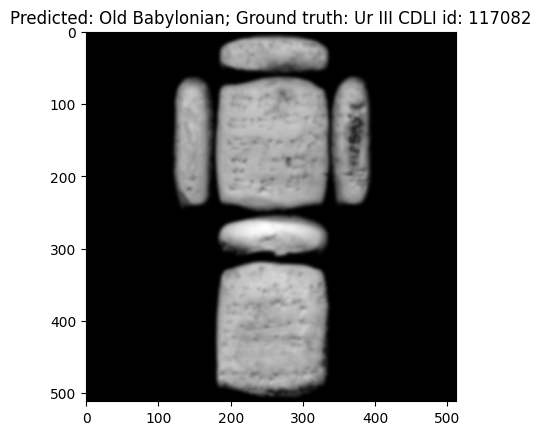

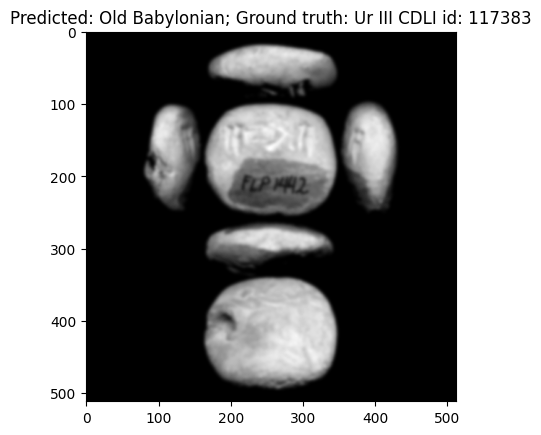

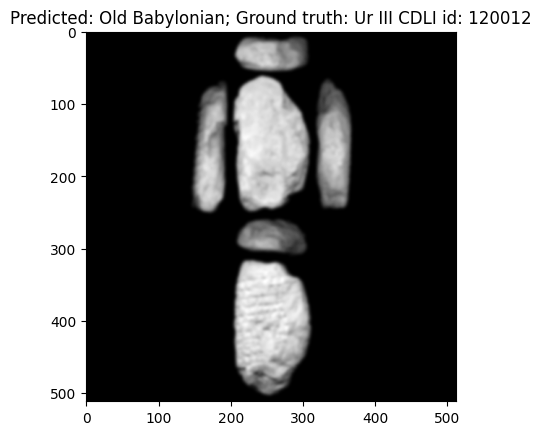

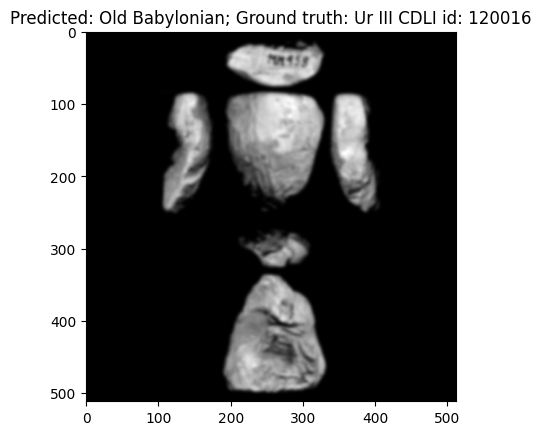

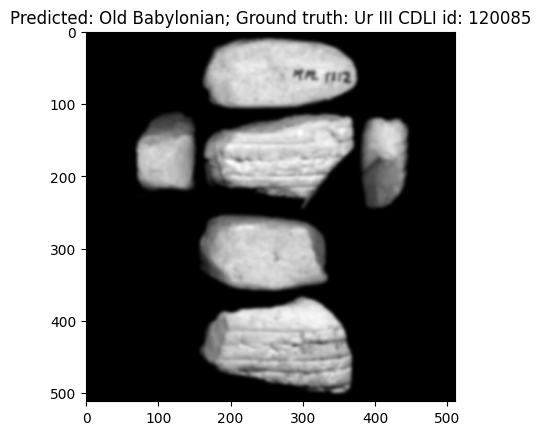

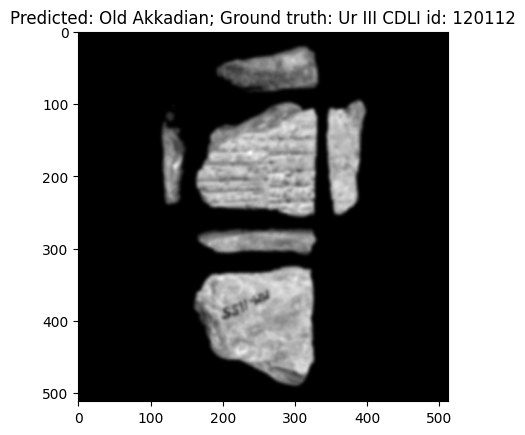

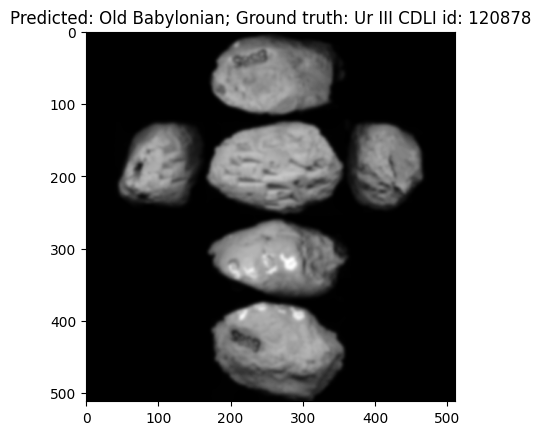

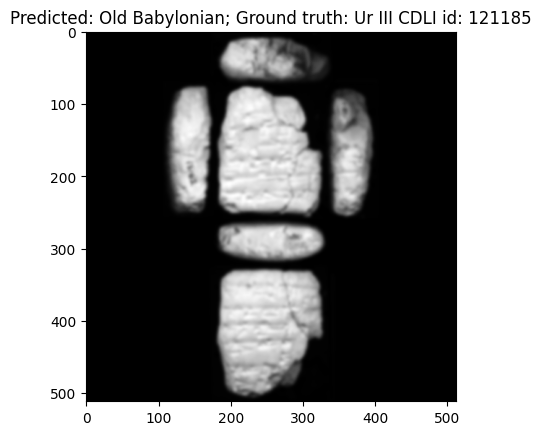

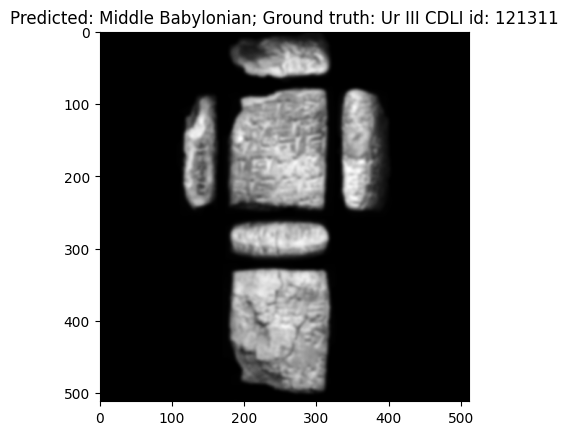

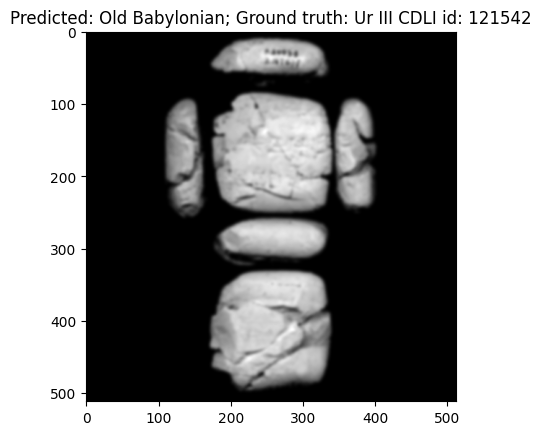

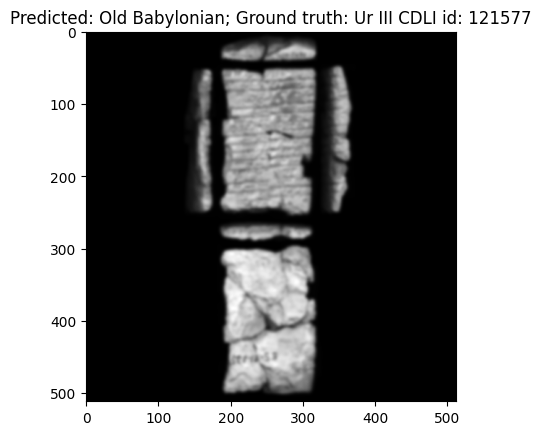

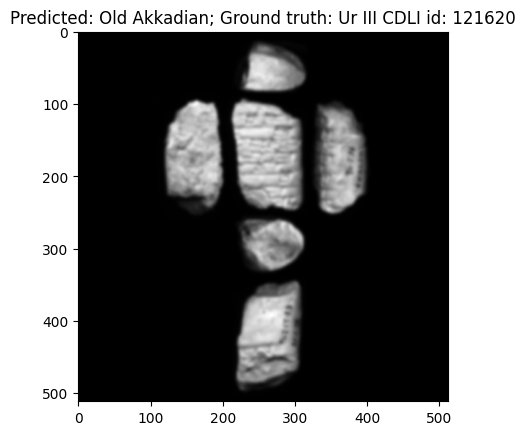

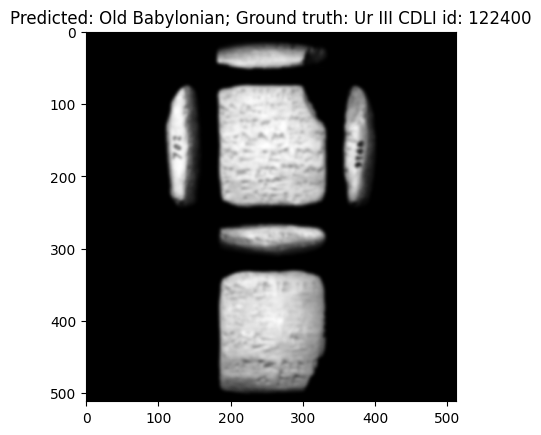

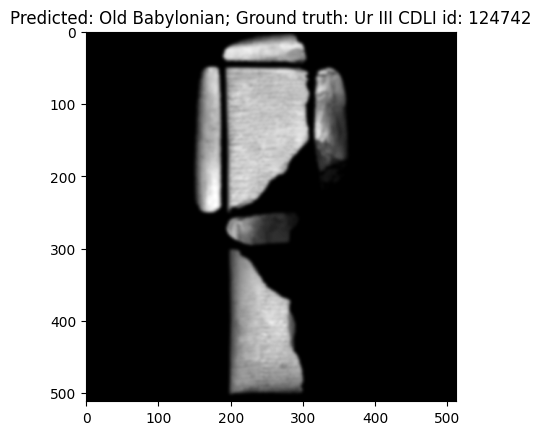

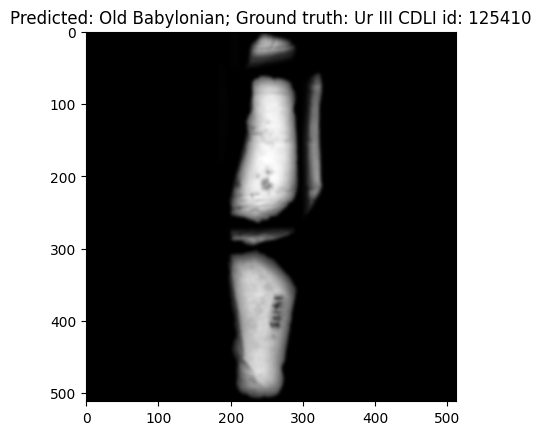

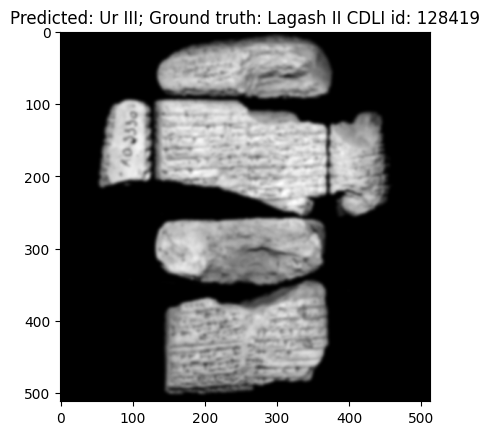

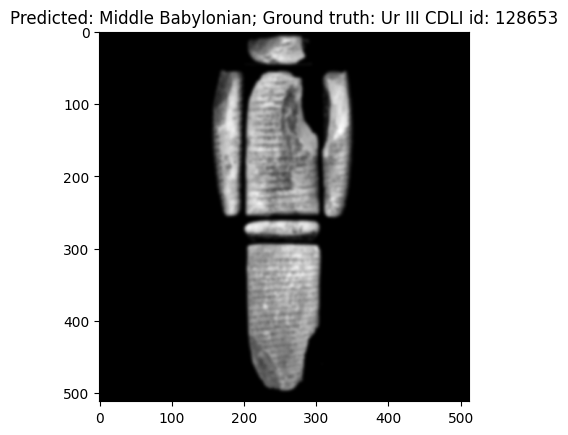

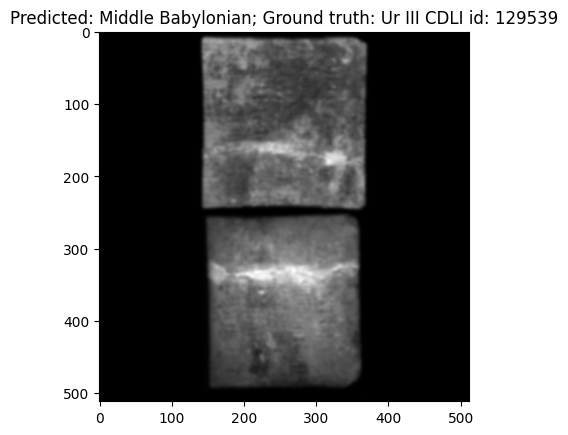

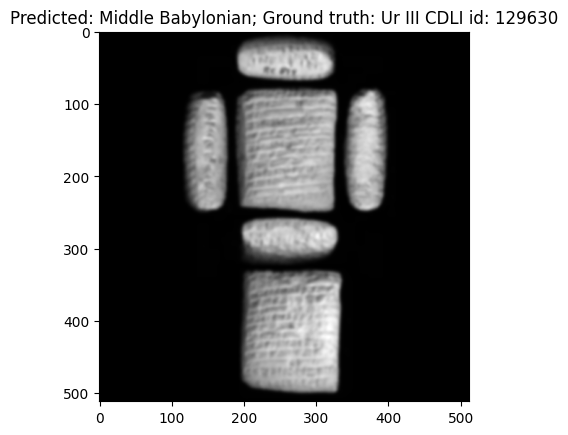

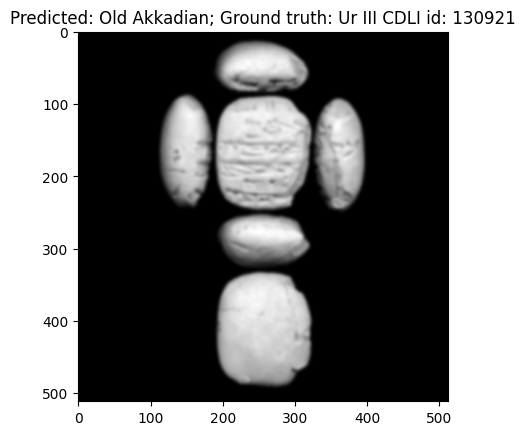

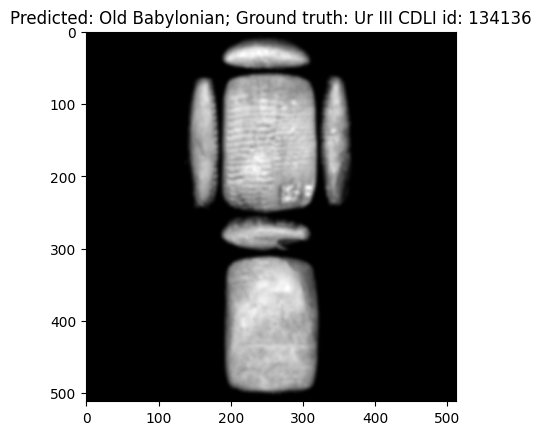

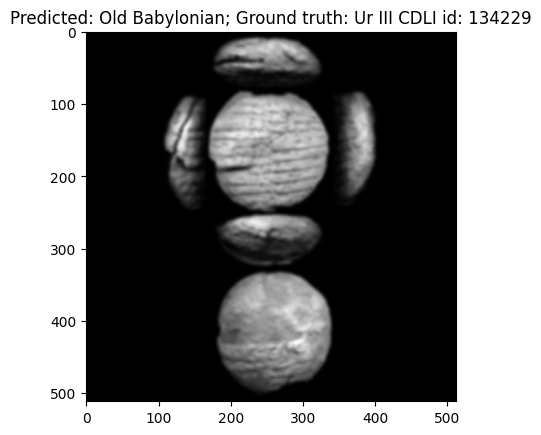

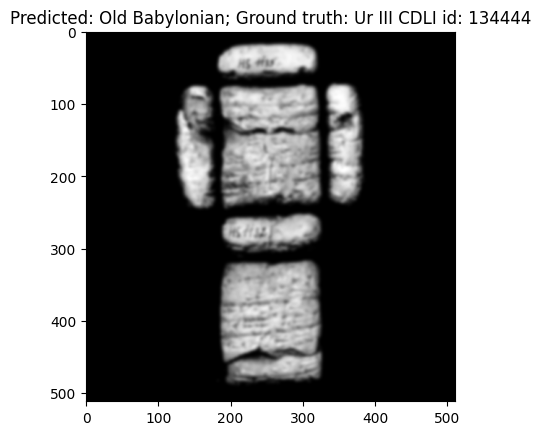

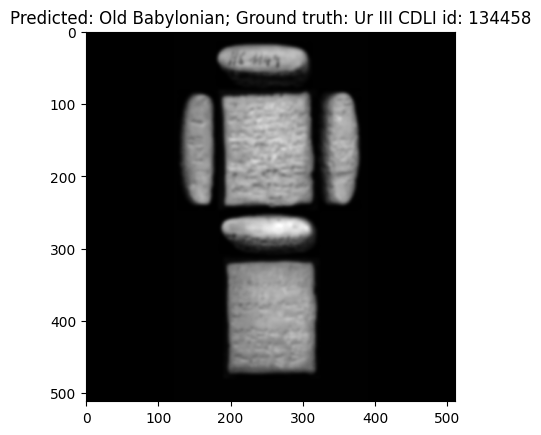

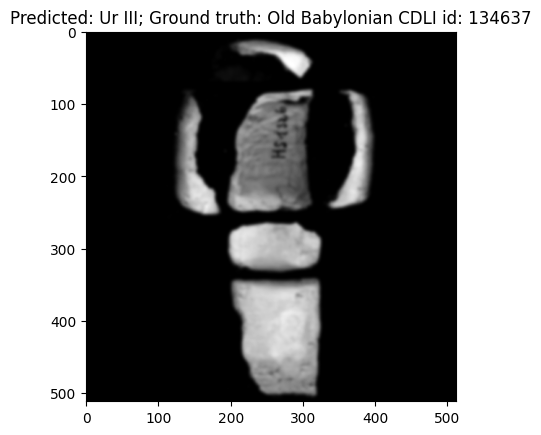

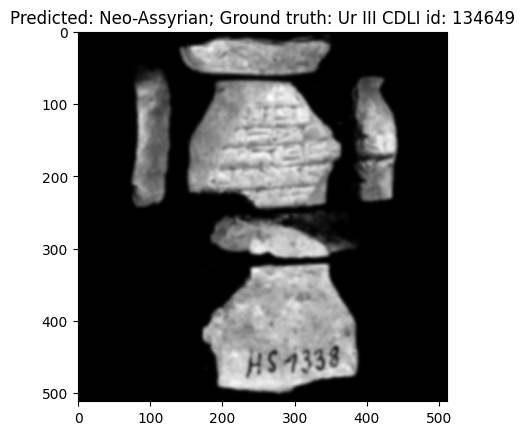

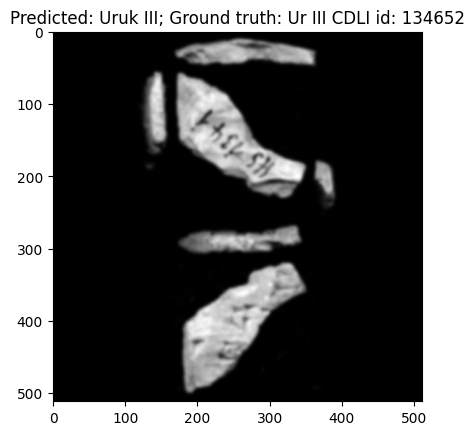

In [66]:
for idx in mistake_indices[10:50]:
    
    cdli_id, X, y, _, _ = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2period[pred]}; Ground truth: {idx2period[y]} CDLI id: {cdli_id}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [72]:
# def preprocess_transform(img):
#     return img

In [73]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [74]:
# explainer = lime_image.LimeImageExplainer()

In [75]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [76]:
# for i in range(10):
#     explain_idx(i)